In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst

In [2]:
df = pd.read_csv('parkfield_earthquakes_1950-2017.csv', skiprows=2, parse_dates=['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9991 entries, 0 to 9990
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             9991 non-null   datetime64[ns]
 1   latitude         9991 non-null   float64       
 2   longitude        9991 non-null   float64       
 3   depth            9991 non-null   float64       
 4   mag              9991 non-null   float64       
 5   magType          9991 non-null   object        
 6   nst              9990 non-null   float64       
 7   gap              9990 non-null   float64       
 8   dmin             9959 non-null   float64       
 9   rms              9989 non-null   float64       
 10  net              9991 non-null   object        
 11  id               9991 non-null   object        
 12  updated          9991 non-null   object        
 13  place            9991 non-null   object        
 14  type             9991 non-null   object 

First part: Earthquake magnitudes

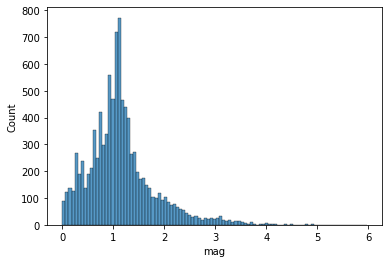

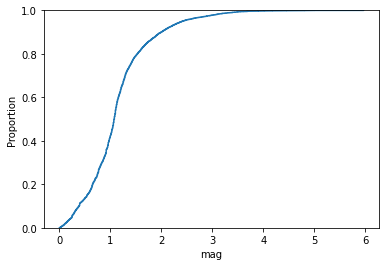

In [3]:
# Graphical EDA
# 1. Distribution of magnitude
_ = sns.histplot(data=df, x='mag')
plt.show()
_ = sns.ecdfplot(data=df, x='mag')
plt.show()

In [4]:
# 2. Compute b-value
def b_value(mag:np.array, mt:int, perc=[2.5,97.5], n_reps=None):
    '''
    Computes b_value of earthquake magnitudes
    mag = earthquake magnitudes
    mt = complete threshold of the earthquake
    perc = percentiles for confidence interval of bootstrap replicates, only n_reps is not None
    n_reps = bootstrap replicates to calculate

    return
    b_value if n_reps is None
    mean_b_value, confidence_interval
    '''
    # keep only mag above threshold
    mags_over_threshold = mag[mag >= mt]

    # no bootstrap replicates needed, just one calculation
    if n_reps == None:
        b_value = (np.mean(mags_over_threshold) - mt) * np.log(10)
        return b_value
    # calculate bootstrap replicates and confidence interval
    else:
        b_values = np.empty(n_reps)
        for i in range(n_reps):
            sample_mags = np.random.choice(mags_over_threshold, size=len(mags_over_threshold), replace=True)
            b_value = (np.mean(sample_mags) - mt) * np.log(10)
            b_values[i] = b_value
        return np.mean(b_values), np.percentile(b_values, perc)

# calculate average magnitude and b-value
mag = np.array(df['mag'])
mt = 3
print('average magnitude =', np.mean(mag))
b, conf_int = b_value(mag, mt, n_reps=1000)
print('b_value =', b, 'w/ 95% CI', conf_int)

average magnitude = 1.1543148833950558
b_value = 1.0815970822053573 w/ 95% CI [0.92796738 1.24831581]


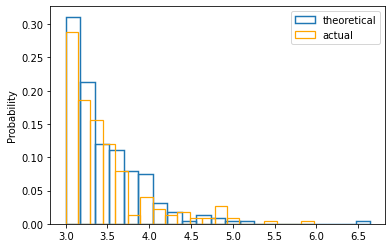

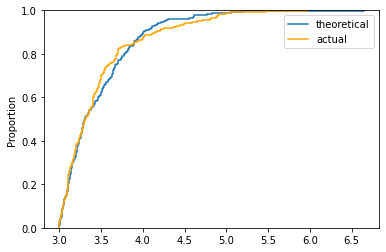

In [5]:
# 3. Prove Gutenberg-Richter Law
# Magnitudes of earthquakes are exponentially distributed
# Compare actual magnitudes over the threshold to that from the b_value
m_actual = mag[mag >= mt]
m_theor = np.random.exponential(scale=b/np.log(10), size=len(m_actual)) + mt

# Histogram
_ = sns.histplot(data=m_theor, fill=False, stat='probability')
_ = sns.histplot(data=m_actual, color='orange', fill=False, stat='probability')
plt.legend(loc='best', labels=['theoretical', 'actual'])
plt.show()
# ECDF
_ = sns.ecdfplot(data=m_theor)
_ = sns.ecdfplot(data=m_actual, color='orange')
plt.legend(loc='best', labels=['theoretical', 'actual'])
plt.show()

Second part: Time between earthquakes

count                            312
mean         41 days 10:02:36.785000
std      200 days 01:01:31.468865980
min          10 days 00:55:12.370000
25%          11 days 09:28:06.345000
50%          13 days 23:35:15.835000
75%          19 days 12:56:33.345000
max        3122 days 03:52:40.900000
Name: time, dtype: object

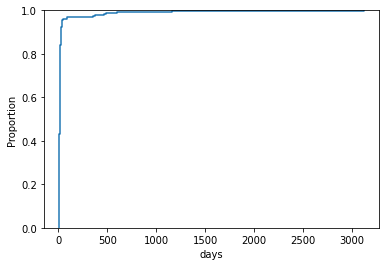

In [6]:
# 1. Get a view of how often earthquakes occur in Parkfield
# sort df by time
df = df.sort_values(by='time', ascending=True)
# calculate time diff between consecutive earthquakes
time_between_eqs = df.time.diff().dropna() # or กรรมกร (df.time - df.time.shift(1))[1:]
# filter our aftershocks
aftershock_threshold = pd.Timedelta(days=10)
time_between_eqs = time_between_eqs[time_between_eqs >= aftershock_threshold]
# describe
display(time_between_eqs.describe())
# plot ecdf
_ = sns.ecdfplot(data=time_between_eqs.dt.days)
_ = plt.xlabel('days')
plt.show()

Most of them are not that far apart but those may be aftershocks.

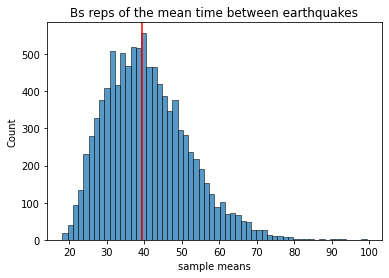

Expected value of time between earthquakes is 40.695891987179486 days with 95% ci (23.454727564102562, 65.47123397435897)


In [7]:
# 2. Infer expected values and confidence interval for time between earthquakes
# days between earthquakes
days_between_eqs = time_between_eqs.dt.days
# draw bs replicates
bs_reps = dcst.draw_bs_reps(days_between_eqs, np.mean, 10000)
# mean and median of bs replicates
bs_reps_mean = np.mean(bs_reps)
bs_reps_median = np.median(bs_reps)
# confidence interval
bs_reps_ci = tuple(np.percentile(bs_reps, [2.5,97.5]))
# plot histogram of bs replicates
ax = sns.histplot(data=bs_reps)
ax.set(title='Bs reps of the mean time between earthquakes', xlabel='sample means')
ax.axvline(bs_reps_median, color='r')
plt.show()
# print out results
print('Expected value of time between earthquakes is {} days with 95% ci {}'.format(bs_reps_mean, bs_reps_ci))

Optional:<br>
We can have many ways to filter out aftershocks and select only major earthquakes.<br>
Some other definitions:<br>
- The next earthquake is the one that has more magnitude than the first one. If the magnitude is lower, consider them as aftershocks<br>
- The aftershock_threshold can be adjusted. 

Third part: Underlying distribution of time between earthquakes<br>
We will use the K-S test to test whether the data at hand is different from theoretical distributions (normal or exponential)


In [8]:
# 1. Calculate parameters from our data to use for the hypothesized distribution 
mean_days_between_earthquakes = np.mean(days_between_eqs)
std_days_between_earthquakes = np.median(days_between_eqs)
print('Mean = {}, Std = {}'.format(mean_days_between_earthquakes, std_days_between_earthquakes))

Mean = 40.94871794871795, Std = 13.0


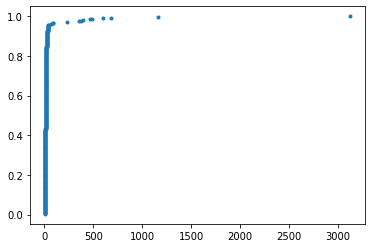

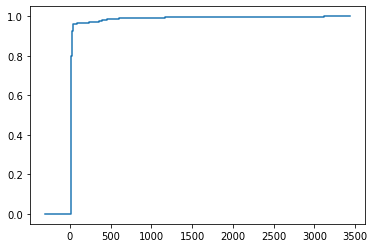

In [9]:
# 2. Formal ecdf vs dot ecdf
_ = plt.plot(*dcst.ecdf(days_between_eqs, formal=False), linestyle='none', marker='.')
plt.show()
_ = plt.plot(*dcst.ecdf(days_between_eqs, formal=True))
plt.show()

In [10]:
# 3. Define function to help calculate K-S stat
def ks_stat(data1, data2):
    '''
    Calculates the ks_stat between two datasets
    '''
    # Compute ECDF from data: x, y
    x, y = dcst.ecdf(data1)
    
    # Compute corresponding values of the target CDF
    cdf = dcst.ecdf_formal(x, data2)

    # Compute distances between concave corners and CDF
    D_top = y - cdf

    # Compute distance between convex corners and CDF
    D_bottom = cdf - y + 1/len(data1)

    return np.max((D_top, D_bottom))

In [ ]:
# x. Theoretical distribution is normal
'''
Null hypothesis: The underlying distribution is normal with the parameters as calculated from the data
Test statistic: K-S stat (max distance between the data ecdf and theoretical cdf)
At least extreme as: the observed K-S stat
'''
# Simulate null hypothesis
theo_normal = np.random.normal(mean_days_between_earthquakes, std_days_between_earthquakes, 10000)
# Calculate bs reps of the test statistic
n = 10000
bs_reps = np.empty(n)
for i in range(n):
    bs_sample = np.random.normal(mean_days_between_earthquakes, std_days_between_earthquakes, len(days_between_eqs))
    bs_reps[i] = ks_stat(bs_sample, theo_normal)
# Calculate observed test statistic
ks_obs = ks_stat(days_between_eqs, theo_normal)
print('Observed test statistic: {}'.format(ks_obs))
# Calculate p-value
p_value = sum(bs_reps >= ks_obs) / len(bs_reps)
print('P-value = {}'.format(p_value))

In [ ]:
# x. Theoretical distribution is exponential
# Simulate null hypothesis
theo_exp = np.random.exponential(mean_days_between_earthquakes, 10000)
# Calculate bs reps of the test statistic
n = 10000
bs_reps = np.empty(n)
for i in range(n):
    bs_sample = np.random.exponential(mean_days_between_earthquakes, len(days_between_eqs))
    bs_reps[i] = ks_stat(bs_sample, theo_exp)
# Calculate observed test statistic
ks_obs = ks_stat(days_between_eqs, theo_exp)
print('Observed test statistic: {}'.format(ks_obs))
# Calculate p-value
p_value = sum(bs_reps >= ks_obs) / len(bs_reps)
print('P-value = {}'.format(p_value))

Tummai save chorb hyeeeee